# CI Data Quality

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import datetime
import collections
import json
from pathlib import Path

import fitsio
import astropy.table
import pandas as pd
import psycopg2

import matplotlib.dates
import matplotlib.animation

## Configuration

In [3]:
cameras = 'CIC', 'CIN', 'CIW', 'CIS', 'CIE'

Define MJD epoch for matplotlib so that date axes show local time:

In [4]:
plot_epoch = matplotlib.dates.date2num(datetime.datetime(1858, 11, 16, 17))

## Databases

Utilities for querying the exposures and telemetry databases.

In [5]:
db_config = dict(
    host='desi-db',
    database='desi_dev',
    user='desi_reader',
    password='reader',
    port=5442
)

In [6]:
class DB(object):
    def __init__(self):
        global db_config
        if db_config is None:
            db_config = yaml.safe_load(open('db.yaml'))
        self.conn = psycopg2.connect(**db_config)
    def query(self, sql, dates=None):
        return pd.read_sql(sql, self.conn, parse_dates=dates)
    def select(self, table, what, where=None, limit=10, order=None, dates=None):
        sql = f'select {what} from {table}'
        if where is not None:
            sql += f' where {where}'
        if order is not None:
            sql += f' order by {order}'
        if limit is not None:
            sql += f' limit {limit}'
        return self.query(sql, dates)

In [7]:
db = DB()

In [28]:
class Exposures(object):
    
    def __init__(self, db, columns='*', cachesize=1000):
        # Run a test query.
        test = db.select('exposure.exposure', columns, limit=1)
        self.columns = list(test.columns)
        self.what = ','.join(self.columns)
        self.db = db
        self.cache = collections.OrderedDict()
        self.cachesize = cachesize
        
    def __call__(self, expid, what=None):
        if what is not None and what not in self.columns:
            raise ValueError(f'Invalid column name: "{what}".')
        if expid not in self.cache:
            row = db.select('exposure.exposure', self.what, where=f'id={expid}', limit=1)
            # Cache the results.
            self.cache[expid] = row.values[0]
            # Trim the cache if necessary.
            while len(self.cache) > self.cachesize:
                self.cache.popitem(last=False)
            assert len(self.cache) <= self.cachesize
        values = self.cache[expid]
        if what is None:
            return values
        return values[self.columns.index(what)]

In [29]:
ExpInfo = Exposures(db)

In [11]:
class NightTelemetry(object):
    """Lookup telemetry using a cache of local noon-noon results.
    """
    def __init__(self, db, tablename, columns='*', cachesize=10, timestamp='time_recorded', verbose=False):
        # Run a test query.
        test = db.select('telemetry.' + tablename, columns, limit=1)
        self.db = db
        self.cachesize = int(cachesize)
        self.tablename = tablename
        self.columns = list(test.columns)
        if timestamp not in self.columns:
            self.columns.append(timestamp)
        self.what = ','.join(self.columns)
        self.timestamp = timestamp
        if verbose:
            print(f'Initialized telemetry from {self.tablename} for {self.what}.')
        self.cache = collections.OrderedDict()
        self.MJD_epoch = pd.Timestamp('1858-11-17', tz='UTC')
        self.one_day = pd.Timedelta('1 days')

    def __call__(self, night, what=None, MJD=None):
        if what is not None and what not in self.columns:
            raise ValueError(f'Invalid column name "{what}". Pick from {self.what}.')
        if night not in self.cache or MJD is not None:
            # Calculate local noon on night.
            when = datetime.datetime.strptime(str(night), '%Y%m%d')
            tmin = when.replace(hour=19)
            # Fetch data until local noon the next day.
            tmax = tmin + datetime.timedelta(days=1)
            # Convert to UTC timestamps.
            tmin = pd.Timestamp(tmin, tz='UTC')
            tmax = pd.Timestamp(tmax, tz='UTC')
        if MJD is not None:
            MJD = np.asarray(MJD)
            # Check that the min MJD is within our range.
            timestamp = self.MJD_epoch + MJD.min() * self.one_day
            if timestamp < tmin or timestamp > tmax:
                raise ValueError(f'MJD {MJD.min()} ({timestamp}) not in night {night}.')
            # Check that the max MJD is within our range.
            timestamp = self.MJD_epoch + MJD.max() * self.one_day
            if timestamp < tmin or timestamp > tmax:
                raise ValueError(f'MJD {MJD.max()} ({timestamp}) not in night {night}.')
        if night not in self.cache:
            # Fetch the results.
            results = self.db.select(
                self.tablename, self.what, limit=None,
                where=f"{self.timestamp}>=TIMESTAMP '{tmin}' and {self.timestamp}<=TIMESTAMP '{tmax}'")
            # Convert the timestamp column to MJD.
            results['MJD'] = (results[self.timestamp] - self.MJD_epoch) / self.one_day
            # Cache the results.
            self.cache[night] = results
            # Trim the cache if necessary.
            while len(self.cache) > self.cachesize:
                self.cache.popitem(last=False)
            assert len(self.cache) <= self.cachesize
        # Fetched the cached results.
        results = self.cache[night]
        if what is None:
            return results
        # Select the specified column (in addition to MJD).
        results = results[['MJD', what]]
        if MJD is None:
            return results
        # Interpolate to the specified time (assuming "what" is numeric).
        dtype = results[what].dtype
        if not np.issubdtype(dtype, np.number):
            raise ValueError(f'Nearest neighbor lookup not implemented yet for dtype "{dtype}".')
        return np.interp(MJD, results['MJD'], results[what])

We will use the `tcs_info` table to access guider corrections applied after the PID filter:

In [12]:
TCS = NightTelemetry(db, 'tcs_info')

## Data Access

Get the path to a per-exposure file. Any `{tag}` in the name will be replaced with the exposure ID as an 8-digit zero-padded string.

In [10]:
def getpath(expid, name, night=None):
    night = night or ExpInfo(expid, 'night')
    tag = f'{expid:08d}'
    path = Path('/exposures/desi/') / str(night) / tag / name.format(tag=tag)
    if not path.exists():
        raise ValueError(f'No such path: {path}')
    return str(path)

CIW,CIE and CIC,CIN are swapped before 02-Apr-2019.  Define a wrapper that undoes these swaps when accessing a camera HDU by name.

In [14]:
def swap_cameras(hdus):
    old_map = hdus.hdu_map
    new_map = dict(old_map)
    for old, new in ('ciw', 'cie'), ('cie', 'ciw'), ('cic', 'cin'), ('cin', 'cic'):
        if old in old_map:
            new_map[new] = old_map[old]
            if new not in old_map:
                del new_map[old]
    hdus.hdu_map = new_map
    return hdus

Open a CI sequence FITS file, swapping HDUs if necessary, and perform some validation:

In [27]:
def openCI(expid, verbose=True):
    night = ExpInfo(expid, 'night')
    hdus = fitsio.FITS(getpath(expid, 'ci-{tag}.fits.fz'))
    # Check for an IMAGECAM header.
    hdr = hdus[1].read_header()
    if 'IMAGECAM' not in hdr:
        hdus.close()
        raise RuntimeError(f'Missing IMAGECAM in {path}.')
    # Check that each listed camera has an HDU present.
    missing = []
    expected = hdr['IMAGECAM'].split(',')
    for camera in expected:
        if camera not in hdus:
            missing.append(camera)
    if missing:
        hdus.close()
        raise RuntimeError(f'Missing HDU for {",".join(missing)} in {path}')
    # Fix CIW,CIE and CIC,CIN swaps before 02-Apr-2019.
    cutoff = 20190402
    if night < cutoff:
        if verbose:
            print(f'Swapping CIW,CIE and CIC,CIN for night {night} < {cutoff}.')
        hdus = swap_cameras(hdus)
    return hdus, hdr

Define a generator to iterate over CI FITS files for a table containing `night` and `id` columns:

In [109]:
def CIfiles(exposure_table, verbose=False):
    for name in 'id', 'night':
        if name not in exposure_table.columns:
            raise ValueError(f'Table has no "{name}" column.')
    for _, row in exposure_table.iterrows():
        night, expid = row['night'], row['id']
        if night is None or np.isnan(night) or (night < 20190317 or night > 20190701):
            print(f'Invalid night={night}.')
            continue
        # Pandas upcasts int column to float if it contains any invalid values.
        expid = int(round(expid))
        night = int(round(night))
        try:
            hdus, hdr = openCI(expid, verbose=verbose)
        except RuntimeError as e:
            print(e)
            continue
        # Check that header has consistent NIGHT and EXPID.
        if hdr['NIGHT'] != night:
            print(f'FITS header ({hdr["NIGHT"]} and db ({night}) have different NIGHT.')
            continue
        if hdr['EXPID'] != expid:
            print(f'FITS header ({hdr["EXPID"]} and db ({expid}) have different EXPID.')
            continue
        try:
            yield hdus, hdr, row
        finally:
            hdus.close()

## Visualization

In [75]:
class CIAxes(object):

    def __init__(self, pixsize=1024, aspect=1.5, dpi=100):
        super(CIAxes, self).__init__()
        assert aspect >= 1
        self.fig = plt.figure(figsize=(pixsize / dpi, pixsize / dpi), frameon=False, dpi=dpi)
        self.pixsize = pixsize
        self.axes = {}
        z1, z2 = 1 / (2 + aspect), (1 + aspect) / (2 + aspect)
        w, h = aspect / (2 + aspect), 1 / (2 + aspect)
        zones = {
            'CIN': (z1, z2, w, h),
            'CIW': (z2, z1, h, w),
            'CIS': (z1, 0, w, h),
            'CIE': (0, z1, h, w),
            'CIC': (z1, 0.5 * z2, w, h),
            'TL': (0, z2, h, h),
            'TR': (z2, z2, h, h),
            'BL': (0, 0, h, h),
            'BR': (z2, 0, h, h),
        }
        for zone, (left, bottom, width, height) in zones.items():
            ax = plt.axes((left, bottom, width, height))
            ax.axis('off')
            self.axes[zone] = ax
        self.next_text_y = {'TL': pixsize, 'TR': pixsize, 'BL': 0, 'BR': 0}
        self.fig.canvas.draw()
        
    def align(self, camera, data):
        """Returns a correctly aligned view of data associated with a camera"""
        if camera == 'CIS':
            return data
        elif camera == 'CIE':
            return data[:, ::-1].T
        elif camera == 'CIN':
            return data[::-1,::-1]
        elif camera == 'CIW':
            return data[::-1].T
        elif camera == 'CIC':
            return data[::-1,::-1]
        else:
            raise ValueError(f'Invalid camera: "{camera}".')

    def add_text(self, text, zone='TL', text_pad=4, **kwargs):
        ax = self.axes[zone]
        y = self.next_text_y[zone]
        x = 0 if zone in ('TL', 'TR') else self.pixsize
        if zone in ('TL', 'TR'):
            kwargs['verticalalignment'] = 'top'
        if zone in ('TR', 'BR'):
            kwargs['horizontalalignment'] = 'right'
        kwargs['transform'] = None
        T = ax.text(x, y, text, **kwargs)
        self.fig.canvas.draw()
        bbox = T.get_window_extent(ax.get_renderer_cache())
        self.next_text_y[zone] = bbox.y0 - text_pad if zone in ('TL', 'TR') else bbox.y1 + text_pad
    
    def save(self, fname, close=False):
        self.fig.savefig(fname, frameon=False, transparent=True)
        if close:
            self.fig.clf()

In [71]:
def equalize(A, clip_percent=5):
    """Equalize the values of an array.
    The returned array has values between 0-1 such that clip_percent
    of the values are clipped symmetrically at 0 and 1, and the
    histogram of values between 0 and 1 is flat. This is a non-linear
    transformation and primarily useful for showing small variations
    over a large dynamic range.
    """
    A_flat = A.reshape(-1)
    n = len(A_flat)
    num_clip = round(n * clip_percent / 100.)
    num_clip_lo = num_clip // 2
    num_clip_hi = num_clip - num_clip_lo
    equalized = np.empty_like(A_flat, dtype=float)
    order = np.argsort(A_flat)
    equalized[order] = np.clip(
        (np.arange(n) - num_clip_lo) / float(n - num_clip), 0., 1.)
    return equalized.reshape(A.shape)

In [76]:
def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, \
        'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, \
        'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] // block_shape[0], A.shape[1] // block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

In [78]:
def downsample(data, downsampling, summary=np.mean):
    return summary(block_view(data, (downsampling, downsampling)), axis=(2, 3))

## Calibration Sequences

Analyze all bias / dark calibration exposures from a night:

In [105]:
def stack_calib(exposures):
    nexp = len(exposures)
    # Loop over files.
    frames = {camera: np.zeros((2, 2048, 3072)) for camera in cameras}
    for hdus, hdr, row in CIfiles(exposures):
        for camera in cameras:
            data = hdus[camera].read().astype(float)
            frames[camera][0] += data
            frames[camera][1] += data ** 2
    for camera in cameras:
        frames[camera] /= nexp
        frames[camera][1] -= frames[camera][0] ** 2
        print(f'{camera}: {np.mean(frames[camera][0]):.3f} +/- {np.sqrt(np.mean(frames[camera][1])):.3f} ADU')
    return frames

In [95]:
def plot_calib(frames, idx=0, downsampling=8, label=None, save=None):
    nx, ny = 3072 // downsampling, 2048 // downsampling
    A = CIAxes(2 * ny + nx)
    if label:
        A.add_text(label, 'TL', fontsize=14)
    for camera in cameras:
        data = frames[camera][idx]
        mu, std = np.mean(data), np.std(data)
        data = downsample(data, downsampling, np.median)
        data = A.align(camera, data)
        A.axes[camera].imshow(data, interpolation='none', origin='lower')
        A.add_text(f'{camera}: {mu:.1f} $\pm$ {std:.1f}', fontsize=12)
    if save:
        A.save(save)

In [110]:
def get_bias(night):
    exposures = db.select(
        'exposure.exposure', 'id,night',
        where=f"exptime=0 and sequence='CI' and flavor='zero' and night={night}", limit=None)
    print(f'Found {len(exposures)} bias exposures from {night}.')
    return stack_calib(exposures)

In [ ]:
biasframes = get_bias(20190526)

In [106]:
def get_dark(night, biasframes):
    exposures = db.select(
        'exposure.exposure', 'id,night,exptime',
        where=f"sequence='CI' and flavor='dark' and night={night}", limit=None)
    print(f'Found {len(exposures)} dark exposures from {night}.')
    # Lookup the exposure times and temperatures used...
    stacked = stack_calib(exposures)
    # Subtract per-pixel bias.
    for camera in cameras:
        stacked[camera] -= biasframes[camera]
    return stacked

In [111]:
darkframes = get_dark(20190526, biasframes)

Found 210 dark exposures from 20190526.
CIC: 1019.277 +/- 9.508 ADU
CIN: 1013.753 +/- 10.693 ADU
CIW: 989.330 +/- 9.352 ADU
CIS: 984.420 +/- 10.584 ADU
CIE: 996.015 +/- 9.559 ADU


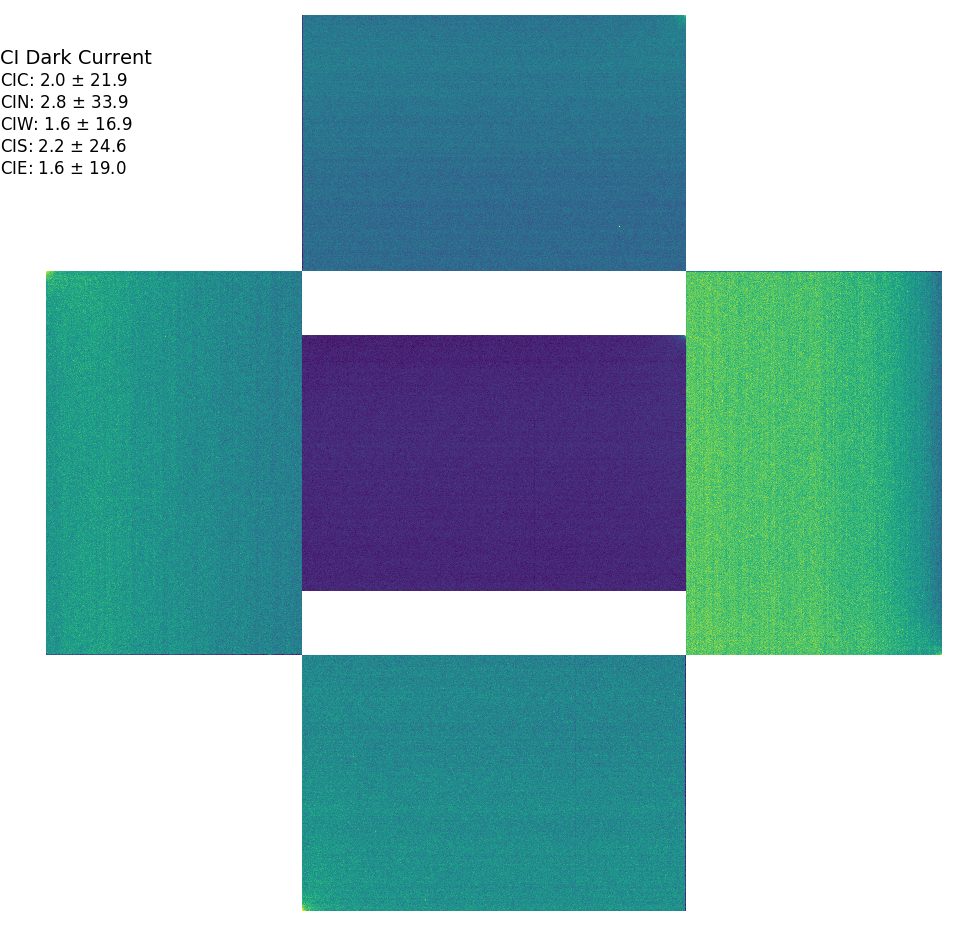

In [112]:
plot_calib(darkframes, 0, label='CI Dark Current', save='dark.png')

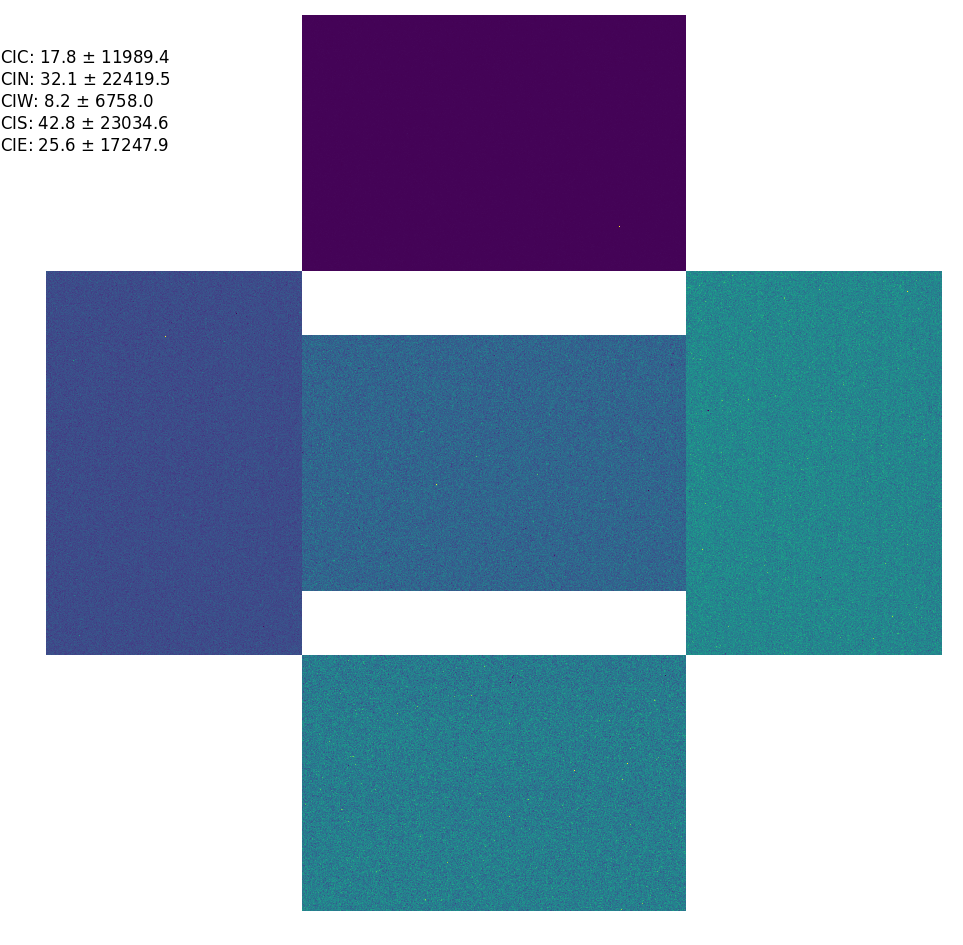

In [113]:
plot_calib(darkframes, 1)

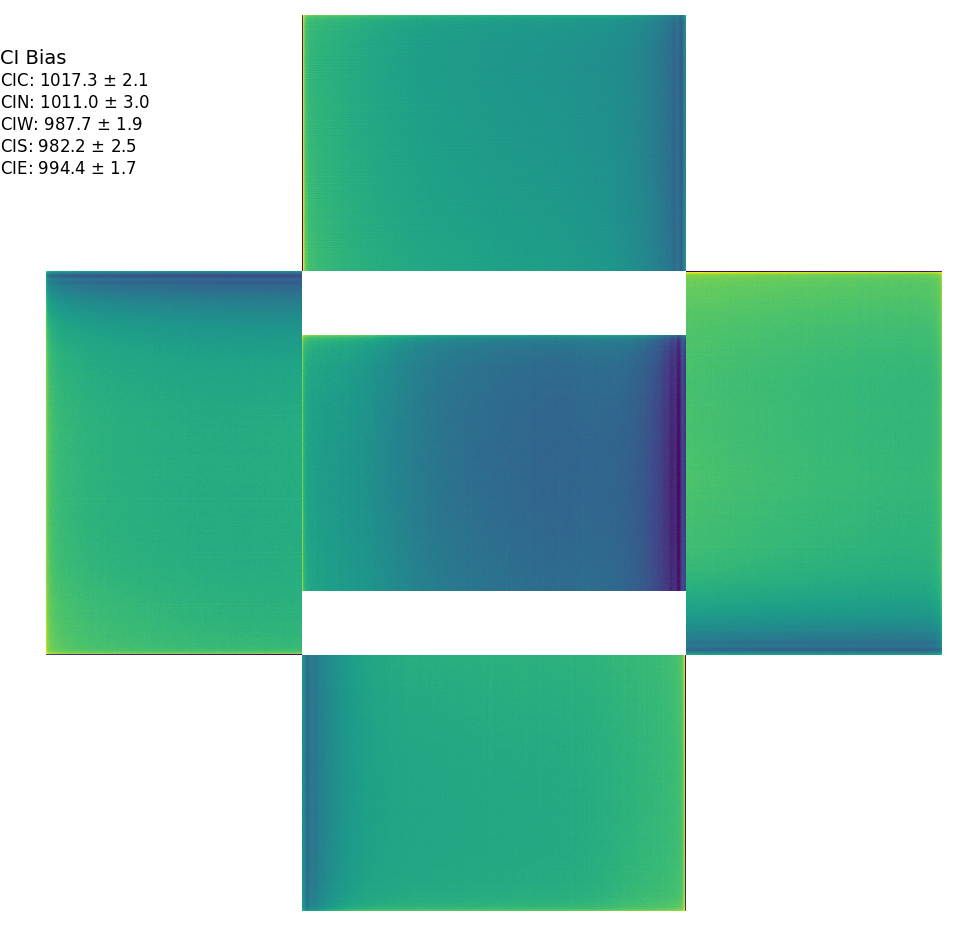

In [99]:
plot_calib(biasframes, 0, label='CI Bias', save='bias.png')

In [3]:
!pwd

/Users/david/Cosmo/DESI/code/DESI-CI/nb


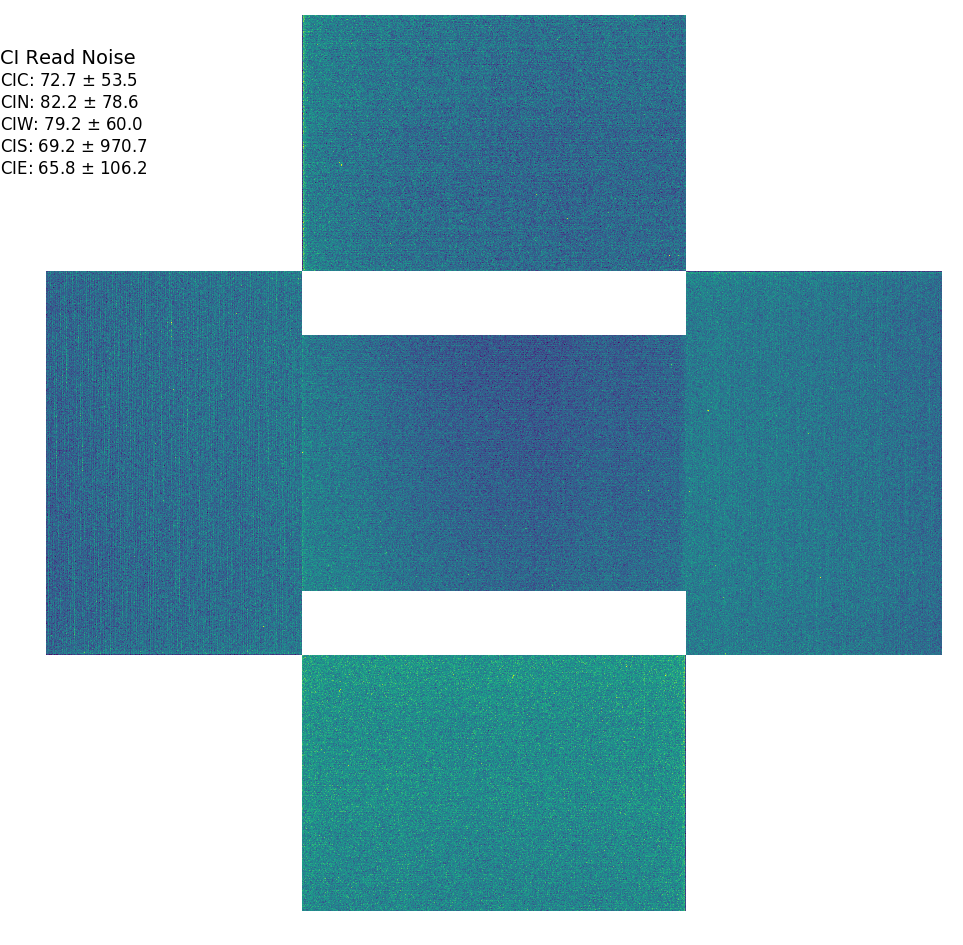

In [100]:
plot_calib(biasframes, 1, label='CI Read Noise', save='readnoise.png')

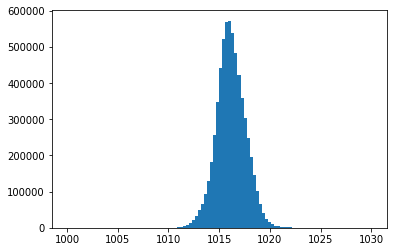

In [66]:
plt.hist(biasframes['CIC'][0].reshape(-1), bins=100, range=(1000, 1030));

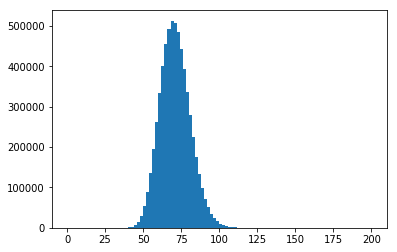

In [69]:
plt.hist(biasframes['CIC'][1].reshape(-1), bins=100, range=(0, 200));

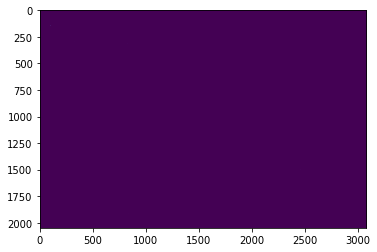

In [70]:
plt.imshow(biasframes['CIC'][1], interpolation='none')

## PM Sequence

Load guider centroids from a PlateMaker (PM) sequence:

In [14]:
def get_centroids(expid, verbose=True):
    # Read the centroid results.
    with open(getpath(expid, 'centroids-{tag}.json')) as f:
        centroids = json.load(f)
    assert centroids['expid'] == expid
    frames = [int(n) for n in centroids['frames'].keys()]
    nframes = max(frames)
    if verbose:
        print(f'Found {nframes} frames.')
    # Count number of guide stars used per camera using the first frame's centroids.
    nstars = {camera: 0 for camera in cameras}
    for key in centroids['frames']['1']:
        if key[:3] not in cameras:
            continue
        nstars[key[:3]] += 1
    offsets = {}
    offsets['combined'] = np.empty((5, nframes))
    for camera in cameras:
        if verbose:
            print(f'{camera} has {nstars[camera]} guide stars.')
        if nstars[camera] == 0:
            continue
        offsets[camera] = np.empty((nstars[camera], 4, nframes))
    # Extract the centroids from each frame.
    for frame in range(1, nframes + 1):
        info = centroids['frames'][str(frame)]
        for i, name in enumerate(('combined_x', 'combined_y', 'tcs_correction_ra', 'tcs_correction_dec', 'guiding')):
            offsets['combined'][i, frame - 1] = info[name]
        for i, name in enumerate(('x_error', 'y_error', 'x_error_wcs', 'y_error_wcs')):
            for camera in cameras:
                for j in range(nstars[camera]):
                    offsets[camera][j, i, frame - 1] = info[f'{camera}_{j}'][name]
    # Lookup the MJD timestamps for each frame of each camera.
    guide = fitsio.FITS(getpath(expid, 'guide-{tag}.fits.fz'))
    MJD = {}
    for camera in cameras:
        meta = astropy.table.Table(guide[camera + 'T'].read())
        MJD[camera] = np.array(meta[1:]['MJD-OBS'])
        assert len(MJD[camera]) == nframes
    guide.close()
    return MJD, offsets, expid

Plot centroids over time from a PM sequence. Use the `annot` argument to add annotations for any conditions changed during the sequence. This can be combined with the previous function, e.g.
```
plot_centroids(*get_centroids(13115), annot='Old PID Coefs|21:02:14|New PID Coefs')
```

In [15]:
def plot_centroids(MJD, offsets, expid, annot='', scale=0.13, showpid=True):
    night = ExpInfo(expid, 'night')
    tile = ExpInfo(expid, 'tileid')
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    colors = {'CIN': 'r', 'CIS': 'b', 'CIW': 'c', 'CIE': 'g', 'CIC': 'y'}
    bad = offsets['combined'][4] == 0
    for camera in cameras:
        if camera not in offsets:
            continue
        t = MJD[camera] + plot_epoch
        c = colors[camera]
        nstars = len(offsets[camera])
        ax[0].plot([], [], ls='-', alpha=0.4, c=c, label=f'{camera}[{nstars}]')
        for i in range(nstars):
            dRA = scale * offsets[camera][i, 2]
            dDEC = scale * offsets[camera][i, 3]
            dRA[bad] = np.nan
            dDEC[bad] = np.nan
            ax[0].plot_date(t, dRA, ls='-', ms=0, xdate=True, c=c, alpha=0.4)
            ax[1].plot_date(t, dDEC, ls='-', ms=0, xdate=True, c=c, alpha=0.4)
    ax[0].plot([], [], 'k-', lw=2, label='Raw')
    if showpid:
        MJDpid, dRA = TCS(night, 'guider_offset_ra').values.T
        MJDpid, dDEC = TCS(night, 'guider_offset_dec').values.T
        tpid = MJDpid + plot_epoch
        sel = (tpid >= t[0]) & (tpid <= t[-1])
        dDEC = -dDEC  # why minus sign needed here??
        ax[0].plot(tpid[sel], dRA[sel] - np.mean(dRA[sel]), c='m', lw=5, alpha=0.2, label='PID')
        ax[1].plot(tpid[sel], dDEC[sel] - np.mean(dDEC[sel]), c='m', lw=5, alpha=0.2)    
    ax[0].legend(ncol=5)
    # Reuse time of last camera plotted for combined correction.
    dRA = -offsets['combined'][2]  # why minus sign needed here??
    dDEC = offsets['combined'][3]
    dRA[bad] = np.nan
    dDEC[bad] = np.nan
    ax[0].plot_date(t, dRA, ls='-', lw=2, c='k', ms=0, xdate=True)
    ax[1].plot_date(t, dDEC, ls='-', lw=2, c='k', ms=0, xdate=True)
    ax[0].set_ylabel('dRA [arcsec]', fontsize=12)
    ax[1].set_ylabel('dDEC [arcsec]', fontsize=12)
    ax[0].axhline(0, c='k', ls='--')
    ax[1].axhline(0, c='k', ls='--')
    ax[0].set_xlim(t[0], t[-1])
    ax[1].set_xlim(t[0], t[-1])
    plt.subplots_adjust(right=0.95, left=0.10, hspace=0.08)
    # Add optional annotations.
    annot = annot.split('|')
    labels = annot[::2]
    times = [t[0]] + [matplotlib.dates.date2num(
        datetime.datetime.strptime(str(night) + when, '%Y%m%d%H:%M:%S'))
             for when in annot[1::2]] + [t[-1]]
    xticks = []
    for i, label in enumerate(labels):
        xticks.append(0.5 * (times[i] + times[i + 1]))
        ax[0].axvline(times[i + 1], ls=':', c='k')
        ax[1].axvline(times[i + 1], ls=':', c='k')
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(labels)
    ax[0].tick_params(axis='x', length=0, labelsize=14)
    ax[1].set_xlabel(f'Local time on {night} for Exposure {expid} on Tile {tile}', fontsize=12)

Found 155 frames.
CIC has 0 guide stars.
CIN has 2 guide stars.
CIW has 0 guide stars.
CIS has 2 guide stars.
CIE has 2 guide stars.


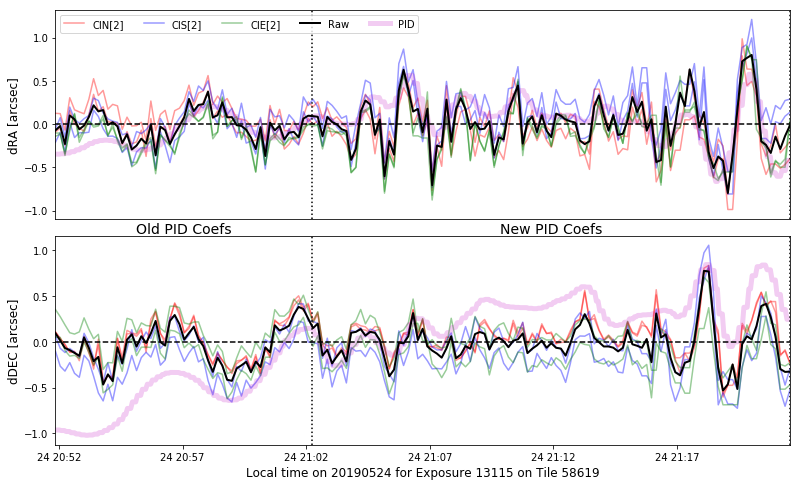

In [16]:
plot_centroids(*get_centroids(13115), annot='Old PID Coefs|21:02:14|New PID Coefs')

Found 52 frames.
CIC has 0 guide stars.
CIN has 2 guide stars.
CIW has 2 guide stars.
CIS has 0 guide stars.
CIE has 0 guide stars.


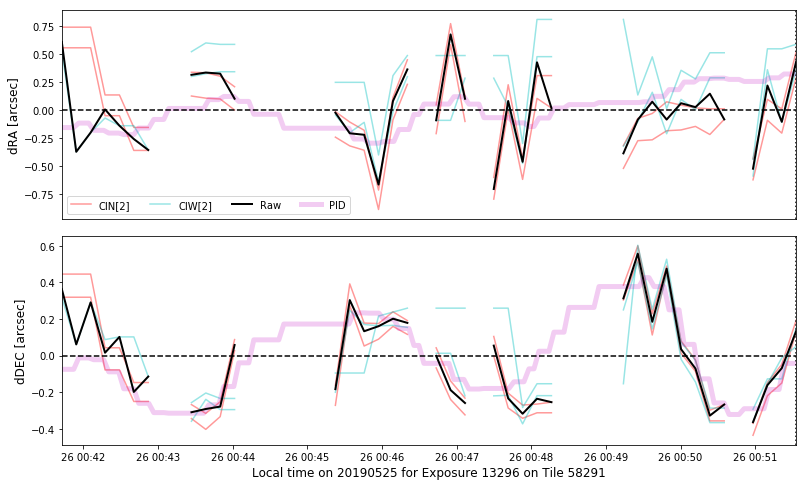

In [17]:
plot_centroids(*get_centroids(13296), showpid=True)

In [439]:
class StampAnimator(object):
    
    def __init__(self, MJD, offsets, expid, maxstamps=2, pixsize=1, pixel_um=9, fiber_um=107):
        self.pixsize = pixsize
        self.offsets = offsets
        self.maxstamps = maxstamps
        self.rois = fitsio.FITS(getpath(expid, 'guide-rois-{tag}.fits.fz'))
        # Get the number of frames, the stamp size, and the pixel value limits to use.
        self.vmin, self.vmax = {}, {}
        for camera, i, cube in self.cubes():
            self.nframes, self.stampsize, _ = cube.shape
            lo, hi = np.percentile(cube, (1, 99))
            if camera in self.vmin:
                lo = min(self.vmin[camera], lo)
            self.vmin[camera] = lo
            if camera in self.vmax:
                hi = max(self.vmax[camera], hi)
            self.vmax[camera] = hi
        # Render an antialiased fiber aperture.
        nos = 10
        n = nos * self.stampsize // 2
        xy = (np.arange(2 * n) - n + 0.5) / nos * pixel_um
        self.fiber = downsample((xy ** 2 + xy.reshape(-1, 1) ** 2 < 0.25 * fiber_um ** 2).astype(float), nos)
        self.rfiber = 0.5 * fiber_um / pixel_um
        
    def cubes(self):
        for camera in cameras:
            if camera not in self.offsets:
                continue
            nstamps = len(self.offsets[camera])
            for i in range(min(nstamps, self.maxstamps)):
                cube = self.rois[f'{camera}_{i}'].read()
                yield camera, i, cube
    
    def _initfigure(self):
        self.image = {}
        self.imshow = {}
        self.artists = []
        # Initialize the figure and axes.
        self.A = CIAxes((2 + self.maxstamps) * self.stampsize * self.pixsize, self.maxstamps)
        for camera in cameras:
            if camera not in self.offsets:
                continue
            self.image[camera] = np.zeros((self.stampsize, self.maxstamps * self.stampsize))
            img = self.image[camera].T if camera in ('CIW', 'CIE') else self.image[camera]
            self.imshow[camera] = self.A.axes[camera].imshow(
                img, interpolation='none', origin='lower', cmap='magma_r', aspect='auto',
                vmin=self.vmin[camera], vmax=self.vmax[camera])
            pos = (self.stampsize - 1) / 2
            pos2 = self.stampsize + pos
            self.A.axes[camera].add_artist(plt.Circle(
                (pos, pos), self.rfiber, ec='w', fc='none', lw=self.pixsize, alpha=0.75))
            x,y = (pos, pos2) if camera in ('CIE', 'CIW') else (pos2, pos)
            self.A.axes[camera].add_artist(plt.Circle(
                (x, y), self.rfiber, ec='w', fc='none', lw=self.pixsize, alpha=0.75))
            self.artists.append(self.imshow[camera])
    
    def _drawframe(self, frame, masked):
        if frame >= self.nframes:
            raise ValueError(f'Invalid frame number {frame} >= {self.nframes}.')
        for camera, i, cube in self.cubes():
            data = cube[frame]
            if masked:
                data = data * self.fiber
            self.image[camera][:, i * self.stampsize:(i + 1) * self.stampsize] = data
        for camera in cameras:
            if camera not in self.offsets:
                continue
            img = self.image[camera].T if camera in ('CIW', 'CIE') else self.image[camera]
            self.imshow[camera].set_data(img)
    
    def frame(self, frame, masked=False):
        self._initfigure()
        self._drawframe(frame, masked)
        
    def animate(self, save, fps, nframes=None, masked=False):
        nframes = nframes or self.nframes
        self._initfigure()
        def init():
            return self.artists
        def update(frame):
            self._drawframe(frame, masked)
            return self.artists
        animation = matplotlib.animation.FuncAnimation(
            self.A.fig, update, init_func=init, blit=True, frames=nframes)
        writer = matplotlib.animation.writers['imagemagick'](
            fps=fps, metadata=dict(artist='DESI'))
        animation.save(save, writer=writer)

In [440]:
SA1 = StampAnimator(*get_centroids(13116))

Found 166 frames.
CIC has 0 guide stars.
CIN has 2 guide stars.
CIW has 0 guide stars.
CIS has 2 guide stars.
CIE has 2 guide stars.


In [441]:
SA2 = StampAnimator(*get_centroids(13023))

Found 53 frames.
CIC has 0 guide stars.
CIN has 2 guide stars.
CIW has 0 guide stars.
CIS has 2 guide stars.
CIE has 2 guide stars.


CPU times: user 10.7 s, sys: 132 ms, total: 10.9 s
Wall time: 25 s


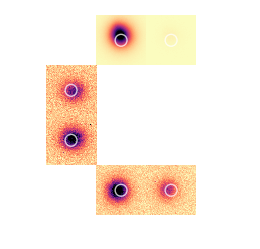

In [443]:
%time SA1.animate('openloop.gif', 5)

CPU times: user 1.54 s, sys: 31.3 ms, total: 1.57 s
Wall time: 6.09 s


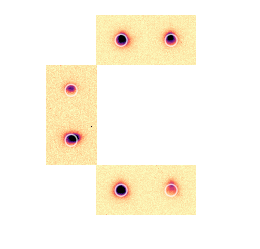

In [442]:
%time SA2.animate('closedloop.gif', 5)

## FVC Sequence

In [58]:
def get_fvc(expid, night):
    if ExpInfo(expid, 'sequence') != 'FVC':
        raise ValueError('Exposure is not an FVC sequence.')
    hdus = fitsio.FITS(getpath(expid, 'fvc-{tag}.fits.fz', night))
    hdr = hdus[0].read_header()
    # Look up the optical geometry.
    meta = dict(
        ADC=[hdr['ADC1PHI'], hdr['ADC2PHI']],
        HEX=[float(X) for X in hdr['FOCUS']])
    # Get the full-frame image.
    data = hdus[1].read()
    hdus.close()
    return data, meta

In [59]:
data, meta = get_fvc(13538, 20190526)

In [60]:
meta

{'ADC': [0.000477999999986878, 0.003886],
 'HEX': [1100.0, -400.0, -329.0, -0.0, 30.0, 0.0]}

In [ ]:
def find_fiducials(data, nfiducials=10):
    ds = downsample(data, 120, np.mean)

In [203]:
ds = downsample(data, 60, np.mean)

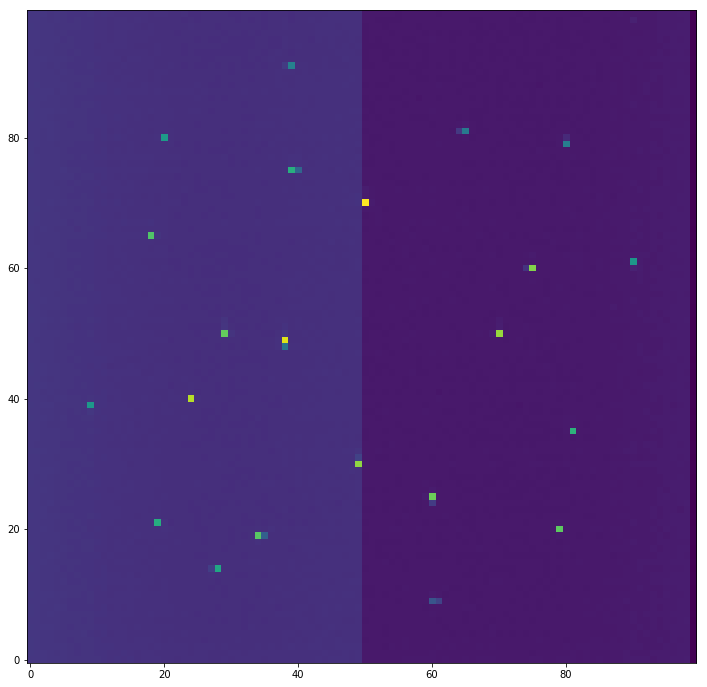

In [204]:
plt.figure(figsize=(12, 12))
plt.imshow(ds, origin='lower', interpolation='none', aspect='auto')

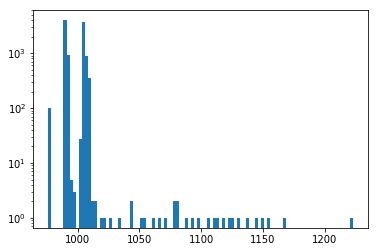

In [56]:
plt.hist(ds.reshape(-1), bins=100);
plt.yscale('log')

In [13]:
hdus[0].read_header()


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                  -64 / number of bits per data pixel
NAXIS   =                    1 / number of data axes
NAXIS1  =                    1 / length of data axis 1
EXTEND  =                    T / FITS dataset may contain extensions
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
EXTNAME = 'FVC     '
EXPID   =                13066
MODULE  = 'FVC     '
EXPTIME = '        '
REQTIME =                   1.
IMAGECAM= 'FVC     '
OBSERVER= 'DESIObserver'
PROPID  = '2015A-0001'
PROGRAM = 'FVC Exposure with ADC1 = 0.0 ADC2 = 0.0'
LEAD    = 'RunManager'
RADESYS = 'FK5     '
TIMESYS = 'UTC     '
EPOCH   =                2000.
DOSVER  = 'current '
OCSVER  =                  1.2
INIFILE = '/n/home/msdos/dos_home/architectures/kpno/ci.ini'
INSTRUME= 'DESI    '
CONSTVER= 'DESI:CURRENT'
CORRCTOR= 'DESI Corrector'
TE

In [15]:
hdus[1].read_header()


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                    8 / width of table in bytes
NAXIS2  =                 6000 / number of rows in table
PCOUNT  =             30709282 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                    1 / number of fields in each row
TTYPE1  = 'COMPRESSED_DATA'    / label for field   1
TFORM1  = '1PB(5166)'          / data format of field: variable length array
ZIMAGE  =                    T / extension contains compressed image
ZSIMPLE =                    T / file does conform to FITS standard
ZBITPIX =                   16 / data type of original image
ZNAXIS  =                    2 / dimension of original image
ZNAXIS1 =                 6000 / length of original image axis
ZNAXIS2 =                 6000 / length of original image axis
ZTILE1  =            